In [28]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader
import random
from collections import defaultdict
import time

In [29]:
transform = transforms.ToTensor()
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

In [30]:
def load_kmnist_for_wisard():
    transform = transforms.ToTensor()
    train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

    x_train = train_dataset.data.numpy()
    y_train = train_dataset.targets.numpy()
    x_test = test_dataset.data.numpy()
    y_test = test_dataset.targets.numpy()

    x_train_bin = (x_train > 127).astype(int).reshape(-1, 784)
    x_test_bin = (x_test > 127).astype(int).reshape(-1, 784)

    return x_train_bin, y_train, x_test_bin, y_test

def load_kmnist_for_cnn(batch_size=64):
    transform = transforms.ToTensor()
    train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

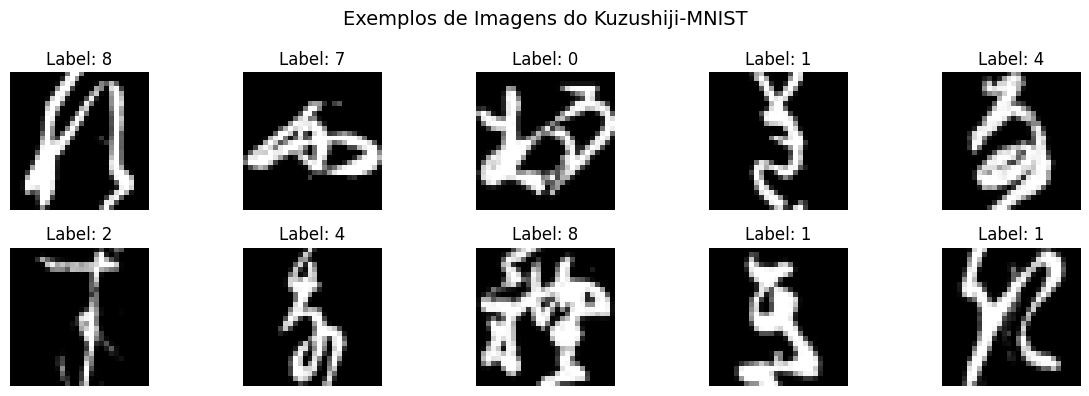

In [31]:
transform = transforms.ToTensor()
visual_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)

plt.figure(figsize=(12, 4))
for i in range(10):
    image, label = visual_dataset[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.suptitle("Exemplos de Imagens do Kuzushiji-MNIST", fontsize=14)
plt.tight_layout()
plt.show()

In [32]:
class Discriminator:
    def __init__(self, input_size, address_size, mapping=None):
        self.input_size = input_size
        self.address_size = address_size
        self.num_rams = input_size // address_size


        if mapping is None:
            positions = list(range(input_size))
            random.shuffle(positions)
            self.mapping = [
                positions[i * address_size:(i + 1) * address_size]
                for i in range(self.num_rams)
            ]
        else:
            self.mapping = mapping

        self.rams = [defaultdict(int) for _ in range(self.num_rams)]

    def train(self, input_bits):
        for i, ram in enumerate(self.rams):
            address = ''.join(str(input_bits[j]) for j in self.mapping[i])
            ram[address] += 1

    def predict(self, input_bits):
        score = 0
        for i, ram in enumerate(self.rams):
            address = ''.join(str(input_bits[j]) for j in self.mapping[i])
            if ram[address] > 0:
                score += 1
        return score

In [33]:
x_train_bin, y_train, x_test_bin, y_test = load_kmnist_for_wisard()

input_size = 784
address_size = 46
classes = list(range(10))


positions = list(range(input_size))
random.shuffle(positions)
shared_mapping = [
    positions[i * address_size:(i + 1) * address_size]
    for i in range(input_size // address_size)
]

discriminators = {
    label: Discriminator(input_size, address_size, mapping=shared_mapping)
    for label in classes
}


start_train = time.time()
for i in range(len(x_train_bin)):
    sample = x_train_bin[i]
    label = y_train[i]
    discriminators[label].train(sample)
end_train = time.time()

print("Treinamento do WiSARD concluído.")
print(f"Tempo de treinamento: {end_train - start_train:.2f} segundos")

def predict_label(sample):
    scores = {
        label: discrim.predict(sample)
        for label, discrim in discriminators.items()
    }

    max_score = max(scores.values())
    for level in reversed(range(max_score + 1)):
        candidatos = [lbl for lbl, score in scores.items() if score >= level]
        if len(candidatos) == 1:
            return candidatos[0]
    return candidatos[0]


start_test = time.time()
correct = 0
for i in range(len(x_test_bin)):
    pred = predict_label(x_test_bin[i])
    if pred == y_test[i]:
        correct += 1
end_test = time.time()

accuracy = 100 * correct / len(x_test_bin)

print(f"Acurácia no teste: {accuracy:.2f}%")
print(f"Tempo de teste: {end_test - start_test:.2f} segundos")

Treinamento do WiSARD concluído.
Tempo de treinamento: 16.17 segundos
Acurácia no teste: 48.25%
Tempo de teste: 24.90 segundos


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [35]:

train_loader, test_loader = load_kmnist_for_cnn(batch_size=64)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 3
start_train = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Época {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
end_train = time.time()
print(f"Tempo de treinamento: {end_train - start_train:.2f} segundos")

model.eval()
correct = 0
total = 0
start_test = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
end_test = time.time()

accuracy = 100 * correct / total
print(f"Acurácia no teste: {accuracy:.2f}%")
print(f"Tempo de teste: {end_test - start_test:.2f} segundos")

Época 1/3, Loss: 0.2982
Época 2/3, Loss: 0.0862
Época 3/3, Loss: 0.0499
Tempo de treinamento: 245.73 segundos
Acurácia no teste: 94.14%
Tempo de teste: 5.58 segundos


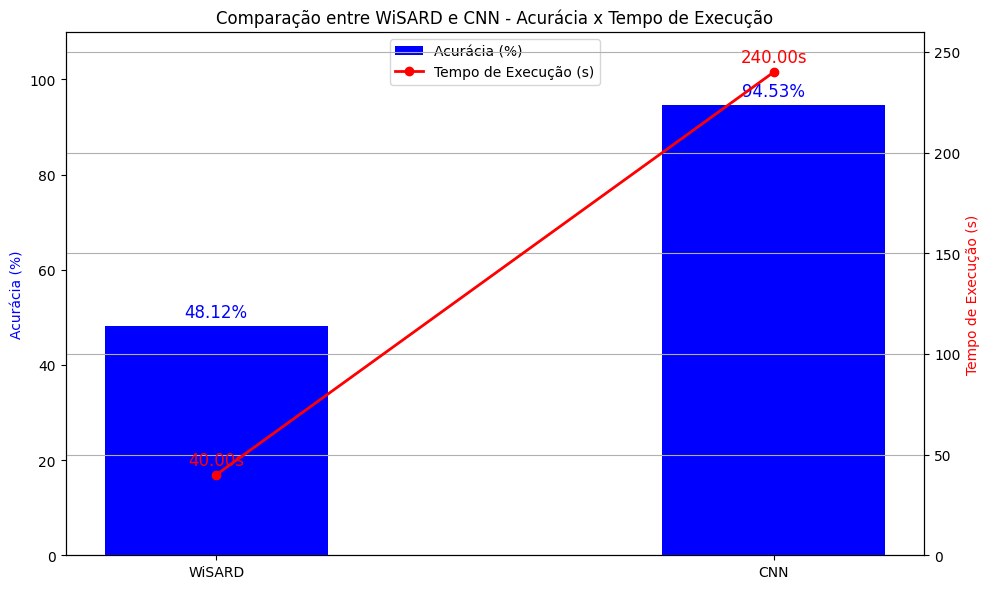

In [39]:
modelos = ['WiSARD', 'CNN']
acuracias = [48.12, 94.53]
tempos = [40.00, 240.00]


fig, ax1 = plt.subplots(figsize=(10, 6))

x = range(len(modelos))

ax1.bar(x, acuracias, width=0.4, label='Acurácia (%)', color='blue', align='center')
ax1.set_ylabel('Acurácia (%)', color='blue')
ax1.set_ylim([0, 110])
ax1.set_xticks(x)
ax1.set_xticklabels(modelos)
ax1.set_title('Comparação entre WiSARD e CNN - Acurácia x Tempo de Execução')

for i, acuracia in enumerate(acuracias):
    ax1.text(i, acuracia + 2, f'{acuracia:.2f}%', ha='center', color='blue', fontsize=12)

ax2 = ax1.twinx()
ax2.plot(x, tempos, label='Tempo de Execução (s)', color='red', marker='o', linewidth=2)
ax2.set_ylabel('Tempo de Execução (s)', color='red')
ax2.set_ylim([0, max(tempos) + 20])

for i, tempo in enumerate(tempos):
    ax2.text(i, tempo + 5, f'{tempo:.2f}s', ha='center', color='red', fontsize=12)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

plt.grid(True)
plt.tight_layout()
plt.show()